## Imports

In [1]:
# Standard
import json
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler

# Scoring
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## Data

In [24]:
file_name = 'gb'
df = pd.read_pickle(f'..\\processed_data\\{file_name}.pki')

In [25]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,TotalIncome,EMI,BalanceIncome
0,LP001002,1,0,0,0,0,1.0,2,1,5849.0,0.347222,5848.652778
1,LP001003,1,1,1,0,0,1.0,0,0,6091.0,0.355556,6090.644444
2,LP001005,1,1,0,0,1,1.0,2,1,3000.0,0.183333,2999.816667
3,LP001006,1,1,0,1,0,1.0,2,1,4941.0,0.333333,4940.666667
4,LP001008,1,0,0,0,0,1.0,2,1,6000.0,0.391667,5999.608333


In [27]:
r = random.randint(1, 100)
train, test = train_test_split(df, test_size=.25, random_state=r)

In [28]:
X = train.drop(['Loan_ID', 'Loan_Status'], axis = 1)
y = train['Loan_Status']
print(X.head())
print(y.head())

     Gender  Married Dependents  Education  Self_Employed  Credit_History  \
99        1        1          0          0              0             1.0   
295       1        1          3          0              0             1.0   
226       1        1          0          1              1             1.0   
356       1        1          2          0              0             1.0   
316       1        1          2          0              0             1.0   

     Property_Area  TotalIncome       EMI  BalanceIncome  
99               1       5300.0  0.363889    5299.636111  
295              2       5666.0  0.305556    5665.694444  
226              2       4735.0  0.383333    4734.616667  
356              0      11500.0  0.458333   11499.541667  
316              1       3717.0  0.333333    3716.666667  
99     1
295    1
226    0
356    1
316    1
Name: Loan_Status, dtype: int32


In [29]:
y.value_counts()

Loan_Status
1    297
0    140
Name: count, dtype: int64

## Hyper-parameter training MLP

In [31]:
# Find the Best Model
param_grid = {
    'hidden_layer_sizes': [200, 300, 400, 500],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [.0001, .001, .01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200]
}

grid_search = GridSearchCV(MLPClassifier(), param_grid=param_grid, cv=5,scoring='f1_weighted', verbose=5, n_jobs=-1)
grid_search.fit(X, y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [200, 300, 400, 500],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [200],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='f1_weighted', verbose=5)

In [33]:
grid_search.best_params_

{'activation': 'logistic',
 'alpha': 0.01,
 'hidden_layer_sizes': 200,
 'learning_rate': 'adaptive',
 'max_iter': 200,
 'solver': 'lbfgs'}

## Bagging

In [34]:
base_model = grid_search.best_estimator_

In [35]:
r = random.randint(1, 101)
model = BaggingClassifier(estimator=base_model, n_estimators=200, bootstrap_features=True, random_state=r, n_jobs=-1)

In [36]:
model.fit(X, y)

BaggingClassifier(bootstrap_features=True,
                  estimator=MLPClassifier(activation='logistic', alpha=0.01,
                                          hidden_layer_sizes=200,
                                          learning_rate='adaptive',
                                          solver='lbfgs'),
                  n_estimators=200, n_jobs=-1, random_state=11)

## Scoring

In [37]:
X_test, y_test = test.drop(columns=['Loan_ID', 'Loan_Status']), test['Loan_Status']

In [38]:
y_pred = model.predict(X_test)

In [39]:
f1_score(y_pred = y_pred, y_true=y_test)

0.9035087719298246

In [40]:
accuracy_score(y_pred = y_pred, y_true=y_test)

0.8493150684931506

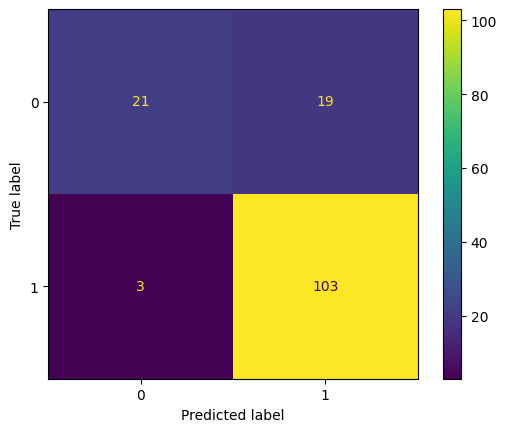

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred = y_pred, y_true=y_test), display_labels=model.classes_)
disp.plot()
plt.show()